# Example script for using the data-driven sampling package


In [2]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.ilr_functions import calculate_sbp_from_hca, make_basis_formula
from src.data_samplers import kmeans_representative_sampling, kcenter_greedy
from src.metric_functions import plot_ecdf

# from scipy.stats import energy_distance
from scipy.spatial.distance import cdist, pdist
from scipy.spatial import ConvexHull
from sklearn.neighbors import KernelDensity

from sklearn.feature_selection import mutual_info_regression


from sklearn.preprocessing import StandardScaler


# MiniBatchKmeans throws a memory leak warning
# but with larger datasets it is not an issue
# if you're concerned uncomment the max cores setting below
import os

os.environ["OMP_NUM_THREADS"] = "2"
# calculate custom with ceil(n_samples / 1024) to avoid memory issues

# alternatively suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


## Define functions

In [3]:
def calculate_energy_distance(X, Y):
    """
    Calculate the energy distance between two datasets X and Y.
    Parameters
    ----------
    X: numpy array of shape (n_samples_X, n_features)
        First dataset.
    Y: numpy array of shape (n_samples_Y, n_features)
        Second dataset.
    Returns
    -------
    float
        The energy distance between datasets X and Y.
    """
    d_xy = cdist(X, Y, metric="euclidean")
    d_xx = cdist(X, X, metric="euclidean")
    d_yy = cdist(Y, Y, metric="euclidean")

    term1 = 2 * d_xy.mean()
    term2 = d_xx.mean()
    term3 = d_yy.mean()

    energy_dist = term1 - term2 - term3
    return energy_dist


## Generate synthetic data

In [7]:
RANDOMSTATE = 42
# set random seed for reproducibility
np.random.seed(RANDOMSTATE)

n_observations = 3000  # number of observations to generate, 
n_samples = 85  # number of samples to take
n_features = 10  # number of features to generate
n_proportion_outliers = 0.2  # proportion of outliers to generate

rng = np.random.default_rng(RANDOMSTATE)
core = rng.normal(
    scale=1.2, size=(int(n_observations * (1 - n_proportion_outliers)), n_features)
)
outliers = rng.uniform(
    -8, 8, size=(int(n_observations * n_proportion_outliers), n_features)
)
X = np.vstack([core, outliers])
# need to shift all so positive, >0
X += np.abs(X.min()) + 1

## Calculate ILR transformation

In [8]:
# put into a DataFrame since 'calculate_sbp_from_hca' expects a DataFrame
df_X = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])
df_X["EXAMPLE_CATEGORICAL"] = np.random.choice(
    ["A", "B", "C"], size=df_X.shape[0], p=[0.3, 0.5, 0.2]
)

df_sbp = df_X.drop(columns="EXAMPLE_CATEGORICAL")
# do any log or scaling to the df_sbp if needed
# not shown here
ilr_embedding = calculate_sbp_from_hca(
    df_sbp.T
)  # make sure analytes/elements are on rows

# make new df to put ilr into (or just use df_X)
df_ilr = df_X[["EXAMPLE_CATEGORICAL"]].copy()
for idx, v in ilr_embedding.items():
    # use ORIGINAL (i.e. untransformed) df_X for the basis calculation
    df_ilr[f"ILR_{idx}"] = make_basis_formula(df_X, v["Numerator"], v["Denominator"])
# you now have a DataFrame with ilr features, you can use it for sampling
# alternatively, transform with CLR


# quick view of the ilr embedding

<Axes: xlabel='ILR_0', ylabel='ILR_2'>

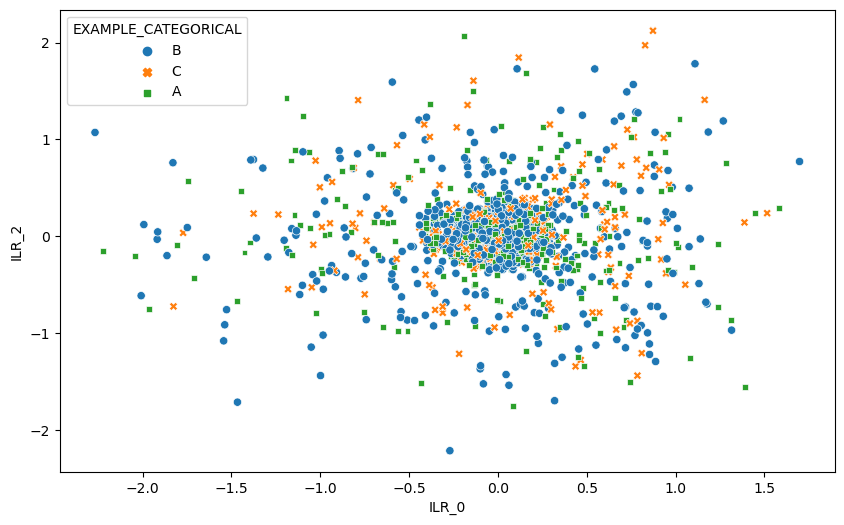

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=df_ilr,
    x="ILR_0",
    y="ILR_2",
    hue="EXAMPLE_CATEGORICAL",
    style="EXAMPLE_CATEGORICAL",
    ax=ax,
)

## Run sampler

To estimate best ratio of centroids to outliers we will step across a range of proportions then plot the maximin distance to the sampled points, using and "elbow" to determine the best ratio

We are also calculating some metrics for later evaluation

In [ ]:
n_steps = 20  # number of steps to take, 20 gives good resolution
maximin_distance_per_step = np.zeros((n_steps,))  # array to hold maximin distances
linspace_ratios = np.linspace(0.1, 1.0, n_steps)  # range of proportions
X_ilr = df_ilr.drop(
    columns="EXAMPLE_CATEGORICAL"
).to_numpy()  # our ilr data as numpy array

# scale if needed
scaler = StandardScaler()
X_ilr = scaler.fit_transform(X_ilr)

# calculate baseline for full data
# these get very expensive with large datasets
vol_full = ConvexHull(X_ilr).volume
kde_full = KernelDensity(bandwidth=0.5).fit(X_ilr)


In [11]:
for idx, prop in enumerate(linspace_ratios):
    n_centroids = max(1, int(n_samples * prop))  # number of centroids to sample

    # I am seriously considering swapping this out for
    # a random or stratified random sampling
    idx_centroids_kmeans = kmeans_representative_sampling(
        X=X_ilr,
        k=n_centroids,
        seed=RANDOMSTATE,
    )
    # sample remainder with kcenter_greedy
    # pass the full n_samples and the already selected centroids
    # the function expects the total number of samples
    idx_centroids_kmeans_greedy = kcenter_greedy(
        X=X_ilr,
        k=n_samples,  # total samples
        metric="euclidean",
        already_selected=idx_centroids_kmeans,  # already selected centroids
        seed=RANDOMSTATE,  # actually ignored in this case
    )
    X_sampled_cent_greedy = X_ilr[idx_centroids_kmeans_greedy, :]
    arry_cent_greedy = cdist(X_ilr, X_sampled_cent_greedy, metric="euclidean").min(
        axis=1
    )
    maximin_distance_per_step[idx] = arry_cent_greedy.max()

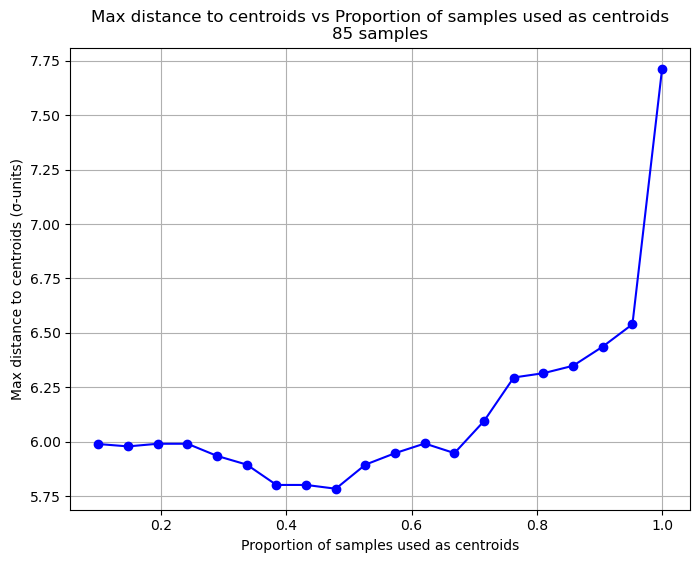

In [12]:
# then plot the maximin distances
# this one does not make much sense b/c generated data is uniform
# but you'll get the idea
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    linspace_ratios,
    maximin_distance_per_step,
    marker="o",
    linestyle="-",
    color="blue",
)
_ = ax.grid()
_ = ax.set_xlabel("Proportion of samples used as centroids")
_ = ax.set_ylabel("Max distance to centroids (σ-units)")
_ = ax.set_title(
    f"Max distance to centroids vs Proportion of samples used as centroids\n{n_samples} samples"
)

## Run sampler with best proportion

In [13]:
optimal_proportion = 0.7  # this is just an example, use the elbow from the plot above
n_centroids = max(
    1, int(n_samples * optimal_proportion)
)  # number of centroids to sample

# again this might be better with random or stratified random sampler
idx_centroids_kmeans_final = kmeans_representative_sampling(
    X=X_ilr,
    k=n_centroids,
    seed=RANDOMSTATE,
)

idx_centroids_kmeans_greedy_final = kcenter_greedy(
    X=X_ilr,
    k=n_samples,  # total samples
    metric="euclidean",
    already_selected=idx_centroids_kmeans_final,  # already selected centroids
    seed=RANDOMSTATE,  # actually ignored in this case
)
X_sampled_cent_greedy_final = X_ilr[idx_centroids_kmeans_greedy_final, :]
df_sampled_ilr = df_ilr.iloc[
    idx_centroids_kmeans_greedy_final, :
].copy()  # Row indices for .iloc (not .loc)
# you might need a different indexer for the raw data
# a sample name column would be ideal
df_sampled_raw = df_X.iloc[
    idx_centroids_kmeans_greedy_final, :
].copy()  # Row indices for .iloc (not .loc)

### We will calculate some metrics to evaluate the sampling performance

In [ ]:
# calculate some metrics on the sampled data
mean_distance_final = np.mean(
    cdist(X_ilr, X_sampled_cent_greedy_final, metric="euclidean").min(axis=1)
)
maximin_distance_final = (
    cdist(X_ilr, X_sampled_cent_greedy_final, metric="euclidean").min(axis=1).max()
)

hull_volume_ratio_final = ConvexHull(X_sampled_cent_greedy_final).volume / vol_full
kde_coverage_final = kde_full.score_samples(X_sampled_cent_greedy_final).mean()
energy_distance_final = calculate_energy_distance(X_ilr, X_sampled_cent_greedy_final)

## Plot up ECDF

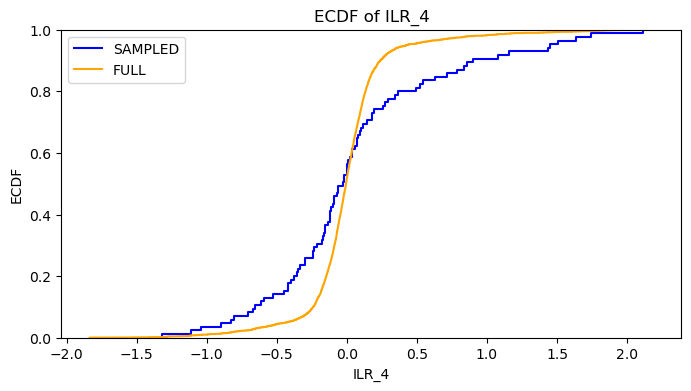

In [15]:
fig, ax = plot_ecdf(
    df_full=df_ilr,
    df_subset=df_sampled_ilr,
    col="ILR_4",  # change to any ILR column you want to compare
    log=False,  # optional
    normalize=False,  # optional, fits on the subset and transforms the full dataset
)

As we can see, the sampling is not great, but ECDF is just one metric, and univariate at that. We will look at some other metrics below. Your sampling plan will come into play here, the current approach tries to capture outliers, which can cause distortion of the distribution depending on relative sample size.

## Compare to random sampling

In [16]:
n_random_draws = 1000
n_samples_random = 85
maximin_distance_random = np.zeros((n_random_draws,))
mean_distance_random = np.zeros((n_random_draws,))
hull_volume_ratio_random = np.zeros((n_random_draws,))
kde_coverage_random = np.zeros((n_random_draws,))
energy_distance_random = np.zeros((n_random_draws,))
for i in range(n_random_draws):
    np.random.seed(RANDOMSTATE + i)  # different seed each iteration
    idx_random = np.random.choice(X_ilr.shape[0], n_samples_random, replace=False)
    X_sampled_random = X_ilr[idx_random, :]
    arry_random = cdist(X_ilr, X_sampled_random, metric="euclidean").min(axis=1)
    maximin_distance_random[i] = arry_random.max()
    mean_distance_random[i] = arry_random.mean()
    hull_volume_ratio_random[i] = ConvexHull(X_sampled_random).volume / vol_full
    kde_coverage_random[i] = kde_full.score_samples(X_sampled_random).mean()
    energy_distance_random[i] = calculate_energy_distance(X_ilr, X_sampled_random)
    if (i + 1) % 100 == 0:
        print(f"Completed {i+1} of {n_random_draws} random draws")

Completed 100 of 1000 random draws
Completed 200 of 1000 random draws
Completed 300 of 1000 random draws
Completed 400 of 1000 random draws
Completed 500 of 1000 random draws
Completed 600 of 1000 random draws
Completed 700 of 1000 random draws
Completed 800 of 1000 random draws
Completed 900 of 1000 random draws
Completed 1000 of 1000 random draws


## Plots comparing the two sampling methods

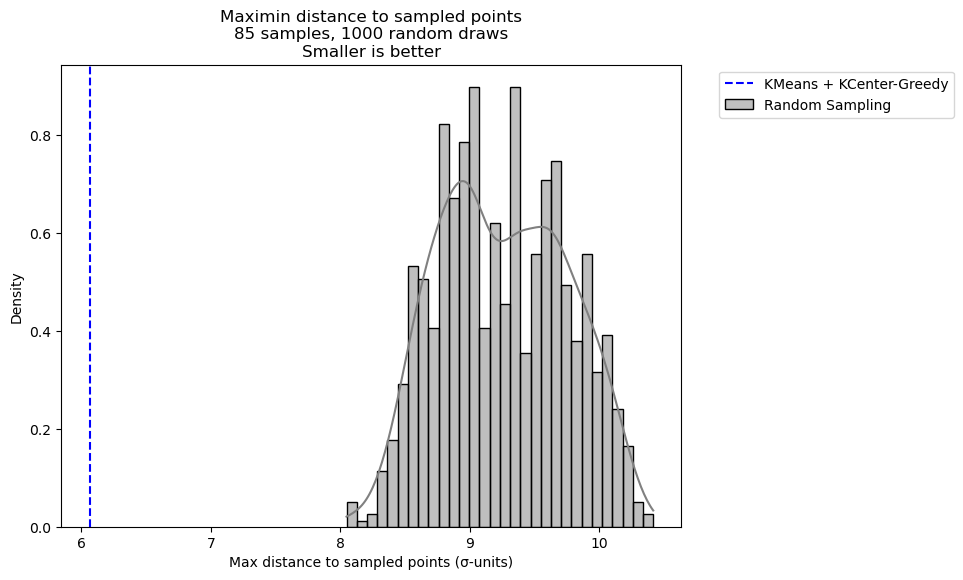

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    maximin_distance_random,
    bins=30,
    kde=True,
    color="gray",
    stat="density",
    label="Random Sampling",
    ax=ax,
)
ax.axvline(
    maximin_distance_final,
    color="blue",
    linestyle="--",
    label="KMeans + KCenter-Greedy",
)
_ = ax.set_xlabel("Max distance to sampled points (σ-units)")
_ = ax.set_ylabel("Density")
_ = ax.set_title(
    f"Maximin distance to sampled points\n{n_samples_random} samples, {n_random_draws} random draws\nSmaller is better"
)
_ = ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

Our sampler gets much smaller maximin, which is by design.

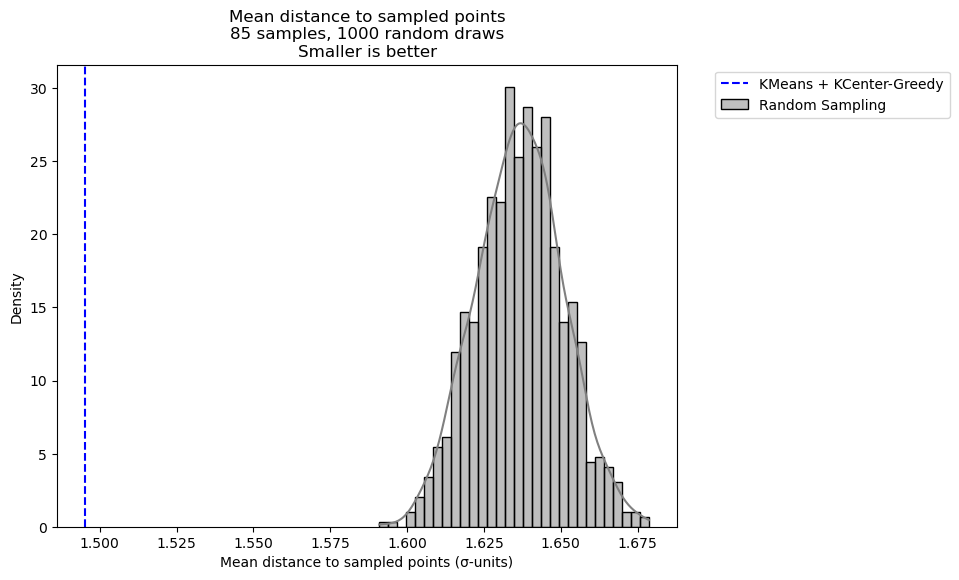

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    mean_distance_random,
    bins=30,
    kde=True,
    color="gray",
    stat="density",
    label="Random Sampling",
    ax=ax,
)
ax.axvline(
    mean_distance_final,
    color="blue",
    linestyle="--",
    label="KMeans + KCenter-Greedy",
)

_ = ax.set_xlabel("Mean distance to sampled points (σ-units)")
_ = ax.set_ylabel("Density")
_ = ax.set_title(
    f"Mean distance to sampled points\n{n_samples_random} samples, {n_random_draws} random draws\nSmaller is better"
)
_ = ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

Similarly, we get a much smaller mean distance to sampled points, which is also by design.

Again, on these "coverage" metrics, our sampler performs better than random sampling.

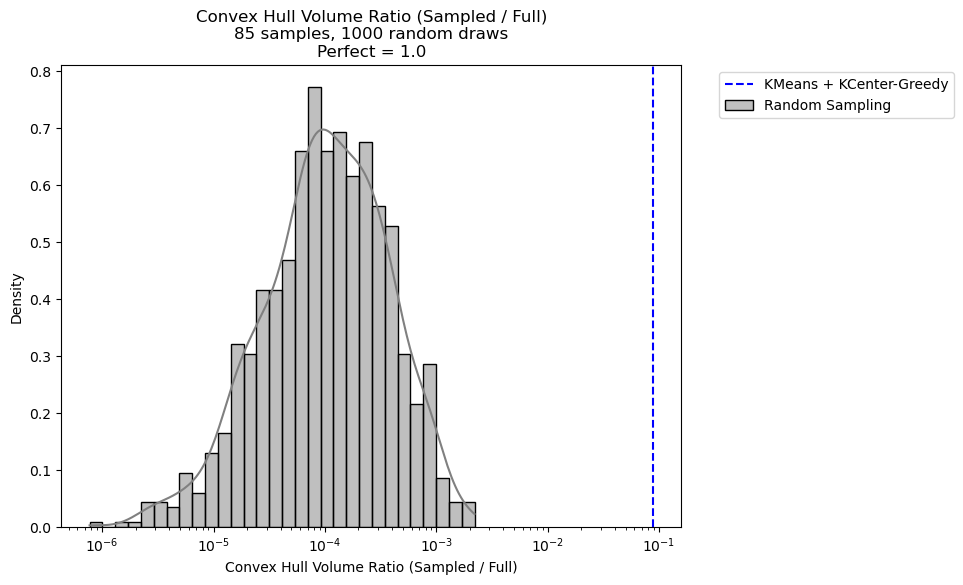

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
_ = ax.set_xscale("log")

sns.histplot(
    hull_volume_ratio_random,
    bins=30,
    kde=True,
    color="gray",
    stat="density",
    label="Random Sampling",
    ax=ax,
)
ax.axvline(
    hull_volume_ratio_final,
    color="blue",
    linestyle="--",
    label="KMeans + KCenter-Greedy",
)
_ = ax.set_xlabel("Convex Hull Volume Ratio (Sampled / Full)")
_ = ax.set_ylabel("Density")
_ = ax.set_title(
    f"Convex Hull Volume Ratio (Sampled / Full)\n{n_samples_random} samples, {n_random_draws} random draws\nPerfect = 1.0"
)
_ = ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

### Now we look at some "distributional" metrics

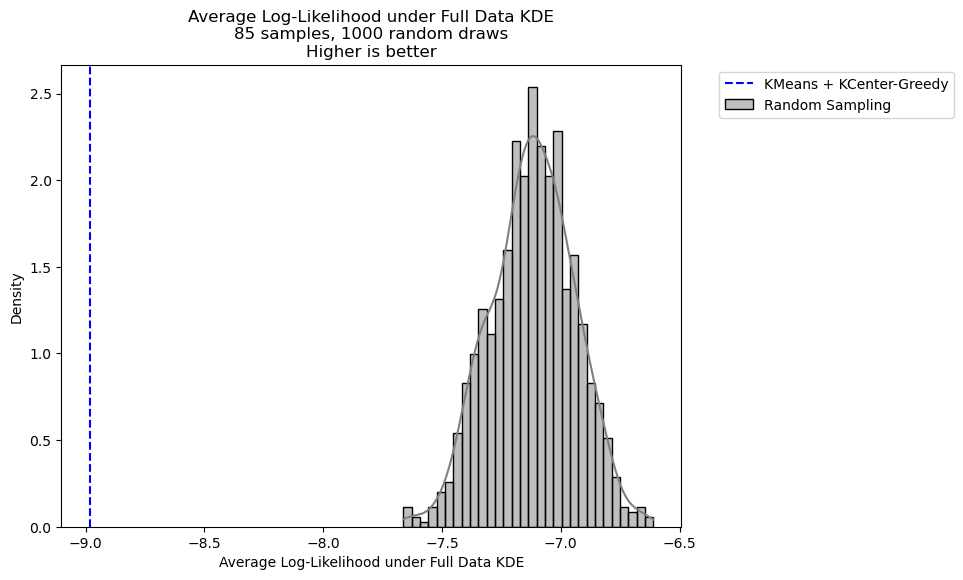

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    kde_coverage_random,
    bins=30,
    kde=True,
    color="gray",
    stat="density",
    label="Random Sampling",
    ax=ax,
)
ax.axvline(
    kde_coverage_final,
    color="blue",
    linestyle="--",
    label="KMeans + KCenter-Greedy",
)
_ = ax.set_xlabel("Average Log-Likelihood under Full Data KDE")
_ = ax.set_ylabel("Density")
_ = ax.set_title(
    f"Average Log-Likelihood under Full Data KDE\n{n_samples_random} samples, {n_random_draws} random draws\nHigher is better"
)
_ = ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

Here we see that the random sampler does better.

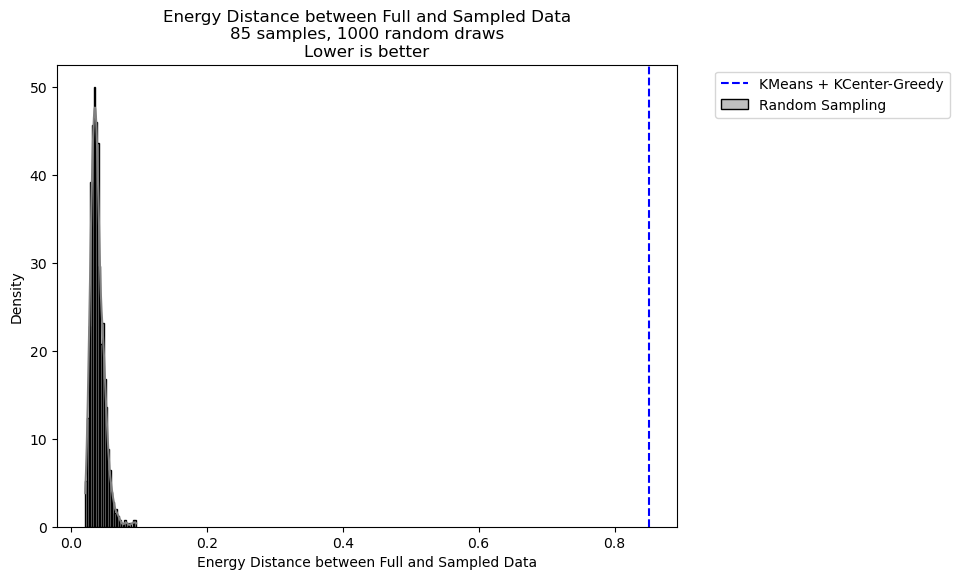

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    energy_distance_random,
    bins=30,
    kde=True,
    color="gray",
    stat="density",
    label="Random Sampling",
    ax=ax,
)
ax.axvline(
    energy_distance_final,
    color="blue",
    linestyle="--",
    label="KMeans + KCenter-Greedy",
)
_ = ax.set_xlabel("Energy Distance between Full and Sampled Data")
_ = ax.set_ylabel("Density")
_ = ax.set_title(
    f"Energy Distance between Full and Sampled Data\n{n_samples_random} samples, {n_random_draws} random draws\nLower is better"
)
_ = ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

For energy distance, the random sampler does better. A randomly drawn sample will tend to be more representative of the distribution, while our sampler is designed to capture outliers, which can distort the distribution.